In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from config import akey

In [24]:
file2 = 'api-data/yearly_summary/ticker_pct_chg_2020.csv'
ticker2020 = pd.read_csv(file2)
ticker2020.head()

,Ticker,pct change,Sector,Industry,Full Time Emp,Year
0,TRST,-21.068702,Financial Services,Banks-Regional,771.0,2020
1,LNTH,-22.791024,Healthcare,Diagnostics & Research,508.0,2020
2,EPRT,-30.174446,Real Estate,REIT-Diversified,27.0,2020
3,MDC,14.384397,Consumer Cyclical,Residential Construction,1656.0,2020
4,VRA,-22.978177,Consumer Cyclical,Footwear & Accessories,2700.0,2020


In [25]:
labels=['xsmall','small','medium','large','xlarge']
ticker2020['Size'] = pd.qcut(ticker2020['Full Time Emp'],q=[0,.2,.4,.6,.8,1], labels=labels)

ticker2020.dropna(how='any',inplace=True)
ticker2020

,Ticker,pct change,Sector,Industry,Full Time Emp,Year,Size
0,TRST,-21.068702,Financial Services,Banks-Regional,771.0,2020,small
1,LNTH,-22.791024,Healthcare,Diagnostics & Research,508.0,2020,xsmall
2,EPRT,-30.174446,Real Estate,REIT-Diversified,27.0,2020,xsmall
3,MDC,14.384397,Consumer Cyclical,Residential Construction,1656.0,2020,medium
4,VRA,-22.978177,Consumer Cyclical,Footwear & Accessories,2700.0,2020,medium
...,...,...,...,...,...,...,...
594,SPPI,48.577236,Healthcare,Biotechnology,146.0,2020,xsmall
595,TRHC,-45.211303,Healthcare,Health Information Services,1286.0,2020,small
596,FSP,-53.535354,Real Estate,REIT-Office,37.0,2020,xsmall
597,HWKN,21.288621,Basic Materials,Specialty Chemicals,656.0,2020,small


In [80]:
results, bin_edges = pd.qcut(ticker2020['Full Time Emp'],q=[0,.2,.4,.6,.8,1], labels=labels, retbins=True)
results_table = pd.DataFrame(zip(bin_edges, labels),columns=['Threshold','Size'])
results_table.to_csv('api-data/bin-thresholds.csv')
results_table

,Threshold,Size
0,0.0,xsmall
1,567.6,small
2,1416.2,medium
3,2790.8,large
4,6179.0,xlarge


In [38]:
sector = ['Basic Materials','Consumer Defensive','Technology']
selected_sectors = ticker2020.loc[ticker2020['Sector'].isin(sector)]
sector_chg = selected_sectors.groupby(['Sector','Size']).mean()
sector_chg.reset_index(inplace=True)
sector_chg

,Sector,Size,pct change,Full Time Emp,Year
0,Basic Materials,xsmall,20.388207,530.000000,2020
1,Basic Materials,small,7.646672,909.833333,2020
2,Basic Materials,medium,9.274269,2143.117647,2020
3,Basic Materials,large,19.385830,4148.125000,2020
4,Basic Materials,xlarge,13.592711,9184.500000,2020
5,Consumer Defensive,xsmall,3.371333,371.500000,2020
6,Consumer Defensive,small,8.967730,1390.000000,2020
7,Consumer Defensive,medium,-3.246707,1970.166667,2020
8,Consumer Defensive,large,10.567510,4081.428571,2020
9,Consumer Defensive,xlarge,19.254288,18006.875000,2020


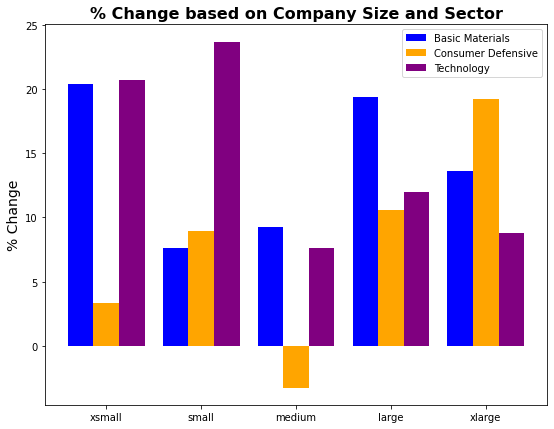

In [54]:
#Found function for adding labels to a bar-chart from Stack Overflow as seen here: 
# https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart
# Modified label to add % symbol at end.
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}%".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


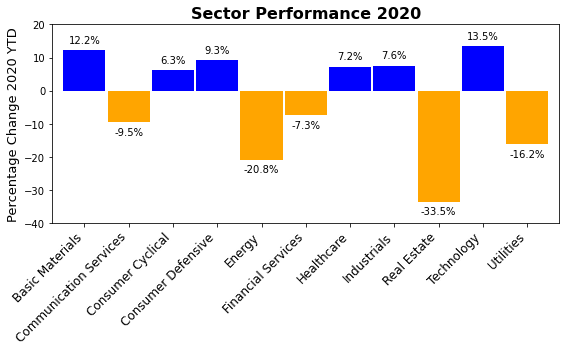

In [79]:
#Bar chart plotting by taking the tickers, grouping by industry and calculating the
#average percentage change of the stocks in each in industry. 
#Then x-axis becomes industry, and y axis is the percentage change. 
w=.95
indchg = ticker2020.groupby('Sector')['pct change'].mean()
industry = indchg.to_frame(name='Pct Chg')
industry.reset_index(inplace=True)
x_labels = industry['Sector'].to_list()
x = np.arange(len(x_labels))
y = industry['Pct Chg']
plt.figure(figsize=(8,5))
ax = y.plot(kind='bar', width=w, color=(y > 0).map({True: 'blue', False:'orange'}))
ax.set_title('Sector Performance 2020', fontsize=16, fontweight='bold')
#ax.set_xlabel('Sector', fontsize=16)
ax.set_ylabel('Percentage Change 2020 YTD', fontsize=13)
ax.set_ylim(-40,20)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, fontsize=12, ha='right')

#Calling function defined above to add labels 
add_value_labels(ax)
plt.tight_layout()
plt.savefig('images/industry_performance_w_labels.png')



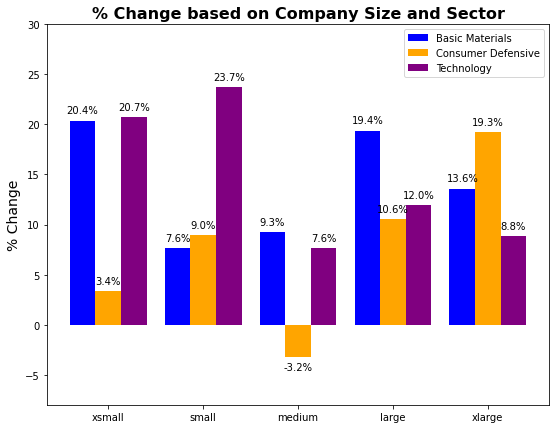

In [64]:
basic = sector_chg[(sector_chg['Sector'] == 'Basic Materials')]['pct change']
defense = sector_chg[sector_chg['Sector'] == 'Consumer Defensive']['pct change']
tech = sector_chg[(sector_chg['Sector'] == 'Technology')]['pct change']
N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111)

yvals = basic
rects1 = ax.bar(ind, yvals, width, color='blue')
zvals = defense
rects2 = ax.bar(ind+width, zvals, width, color='orange')
kvals = tech
rects3 = ax.bar(ind+width*2, kvals, width, color='purple')
ax.set_ylim(-8,30)
ax.set_ylabel('% Change',fontsize=14)
ax.set_title('% Change based on Company Size and Sector',fontsize=16,fontweight='bold')
ax.set_xticks(ind+width)
ax.set_xticklabels(labels)
ax.legend( (rects1[0], rects2[0], rects3[0]), ('Basic Materials', 'Consumer Defensive', 'Technology') )
add_value_labels(ax)

plt.savefig('images/perc_by_size.png')

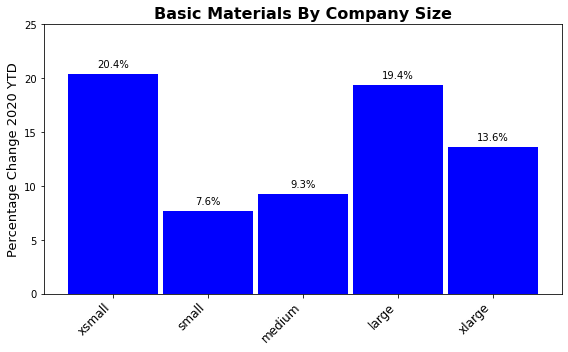

In [72]:
w=.95
x_labels = labels
x = np.arange(len(x_labels))
y = basic
plt.figure(figsize=(8,5))
ax = y.plot(kind='bar', width=w, color='blue')
ax.set_title('Basic Materials By Company Size', fontsize=16, fontweight='bold')
#ax.set_xlabel('Sector', fontsize=16)
ax.set_ylabel('Percentage Change 2020 YTD', fontsize=13)
ax.set_ylim(0,25)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, fontsize=12, ha='right')

#Calling function defined above to add labels 
add_value_labels(ax)
plt.tight_layout()
plt.savefig('images/basic_materials_size.png')


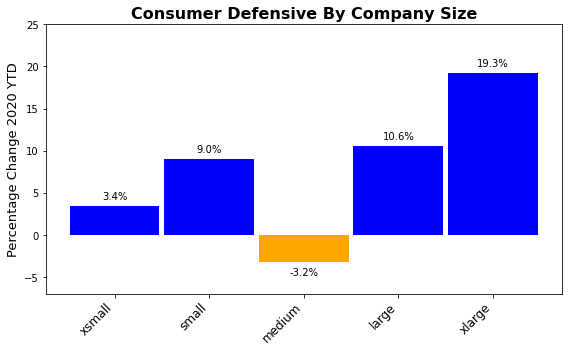

In [75]:
w=.95
x_labels = labels
x = np.arange(len(x_labels))
y = defense
plt.figure(figsize=(8,5))
ax = y.plot(kind='bar', width=w, color=(y > 0).map({True: 'blue', False:'orange'}))
ax.set_title('Consumer Defensive By Company Size', fontsize=16, fontweight='bold')
#ax.set_xlabel('Sector', fontsize=16)
ax.set_ylabel('Percentage Change 2020 YTD', fontsize=13)
ax.set_ylim(-7,25)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, fontsize=12, ha='right')

#Calling function defined above to add labels 
add_value_labels(ax)
plt.tight_layout()
plt.savefig('images/consumer_defensive_size.png')


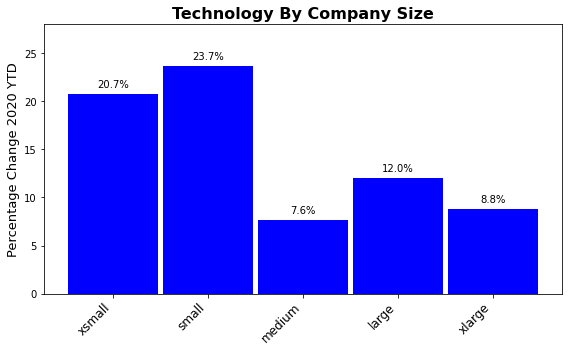

In [78]:
w=.95
x_labels = labels
x = np.arange(len(x_labels))
y = tech
plt.figure(figsize=(8,5))
ax = y.plot(kind='bar', width=w, color='blue')
ax.set_title('Technology By Company Size', fontsize=16, fontweight='bold')
#ax.set_xlabel('Sector', fontsize=16)
ax.set_ylabel('Percentage Change 2020 YTD', fontsize=13)
ax.set_ylim(0,28)
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, fontsize=12, ha='right')

#Calling function defined above to add labels 
add_value_labels(ax)
plt.tight_layout()
plt.savefig('images/technology_size.png')


In [7]:
indchg

Industry
Basic Materials           12.188316
Communication Services    -9.482677
Consumer Cyclical          6.285675
Consumer Defensive         9.328190
Energy                   -20.833857
Financial Services        -7.277631
Healthcare                 7.233188
Industrials                7.555920
Real Estate              -33.506755
Technology                13.548758
Utilities                -16.221258
Name: pct change, dtype: float64

In [30]:
file3 = 'api-data/yearly_summary/prices_for_2020.csv'
stocks = pd.read_csv(file3)
stocks.head()


,Date,Close,Ticker,Year,Month,Sector,Industry,Full Time Emp
0,2020-01-31,7.93,TRST,2020,1,Financial Services,Banks-Regional,771.0
1,2020-01-31,17.51,LNTH,2020,1,Healthcare,Diagnostics & Research,508.0
2,2020-01-31,27.61,EPRT,2020,1,Real Estate,REIT-Diversified,27.0
3,2020-01-31,42.14,MDC,2020,1,Consumer Cyclical,Residential Construction,1656.0
4,2020-01-31,9.58,VRA,2020,1,Consumer Cyclical,Footwear & Accessories,2700.0


In [32]:
sectors = stocks.groupby(['Sector','Date'])['Close'].sum().to_frame(name="close")
sectors.reset_index(inplace=True)
sectors['Date'] = pd.to_datetime(sectors['Date'], format='%Y-%m-%d')
basic = sectors[(sectors['Sector'] == 'Basic Materials')]
defense = sectors[sectors['Sector'] == 'Consumer Defensive'] 
tech = sectors[(sectors['Sector'] == 'Technology')]

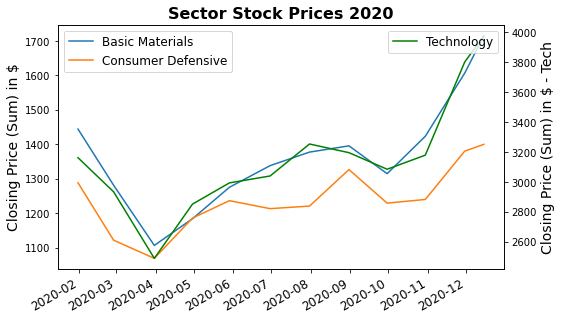

In [34]:
#Set x axis to date of one of the series.
#Plot basic materials and consumer defensive on first y-axis
#Plot Technology on secondary Y axis. Plot all three industry charts on same plot.
x = tech['Date']
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(x,basic['close'],label='Basic Materials')
ax1.plot(x,defense['close'], label='Consumer Defensive')
ax2 = ax1.twinx()
ax2.plot(x,tech['close'], label='Technology', color='green')
ax1.set_title('Sector Stock Prices 2020', fontsize=16, fontweight='bold')
ax1.set_ylabel('Closing Price (Sum) in $', fontsize=14)
ax2.set_ylabel('Closing Price (Sum) in $ - Tech', fontsize=14)
fig.autofmt_xdate()
ax1.tick_params(axis='x', labelsize=12)
leg = ax1.legend(fontsize=12)
leg2 = ax2.legend(loc='upper right', fontsize=12)
fig.savefig('images/selected_sectors.png')

In [35]:
overall = sectors.groupby('Date').close.sum().to_frame(name='Closing Price')
overall.reset_index(inplace=True)
overall

,Date,Closing Price
0,2020-01-31,22293.6150
1,2020-02-28,20091.3550
2,2020-03-31,15774.2144
3,2020-04-30,17633.1160
4,2020-05-29,18568.3071
5,2020-06-30,19148.5000
6,2020-07-31,19909.2300
7,2020-08-31,20658.9600
8,2020-09-30,19811.5803
9,2020-10-30,20288.8400


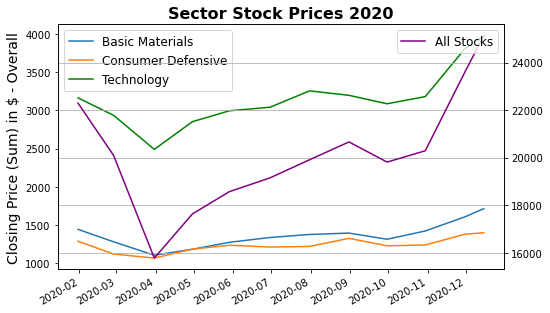

In [36]:
#Plot all three industries against the sum of stock prices for all stocks. 
#Put the "All Stocks" series on a secondary Y axis for visual presentation. 
x = tech['Date']
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(x,basic['close'],label='Basic Materials')
ax1.plot(x,defense['close'], label='Consumer Defensive')
ax2 = ax1.twinx()
ax1.plot(x,tech['close'], label='Technology', color='green')
ax1.set_title('Sector Stock Prices 2020', fontsize=16, fontweight='bold')
ax1.set_ylabel('Closing Price (Sum) in $', fontsize=14)
ax1.set_ylabel('Closing Price (Sum) in $ - Overall', fontsize=14)
plt.grid()
ax2.plot(x,overall['Closing Price'], label='All Stocks', color='purple')
fig.autofmt_xdate()
leg = ax1.legend(fontsize=12)
leg2 = ax2.legend(loc='upper right', fontsize=12)

fig.savefig('images/selected_sectors_vs_all.png')